In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/single_model_profs_new_metrics')
print HOME

/Users/EyalPC/Desktop/plots-model-comp-paper/results/single_model_profs_new_metrics


In [91]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                print np.asarray(item[key]["items"])
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    
    return result, hollistic_data

resnet_models = [
    "tf-resnet-feats"
]

resnet, resnet_hollistic = cache_extractions(HOME+"/"+"results-180220_043817.json", timestamps = True)
# 1/0.02363753667

# taking off the first 25% of the records to be sure the warmup time is removed
for key, value in resnet.iteritems():
    sorted_timestamps = np.argsort(value[:,0])
    value = value[sorted_timestamps] # sort data by timestamps
    resnet[key] = value[value.shape[0]/4:] # cut off the first fourth from warmup effects

for key, value in resnet.iteritems():
    print key, value.shape

model:tf-resnet-feats:1:prediction_latencies_list (1875, 2)
tf-resnet-feats:1:queue_sizes (61602, 2)
tf-resnet-feats:processing_latency (1875, 2)
tf-resnet-feats:1:processing_outs (25701, 2)
tf-resnet-feats:1:queue_arrivals (59739, 2)
app:tf-resnet-feats:prediction_latencies (59512, 2)


In [92]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment)")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

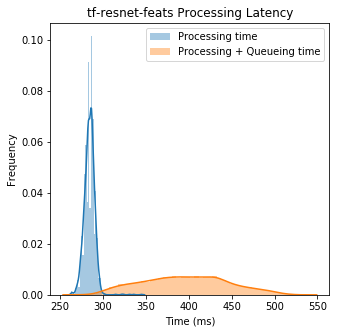

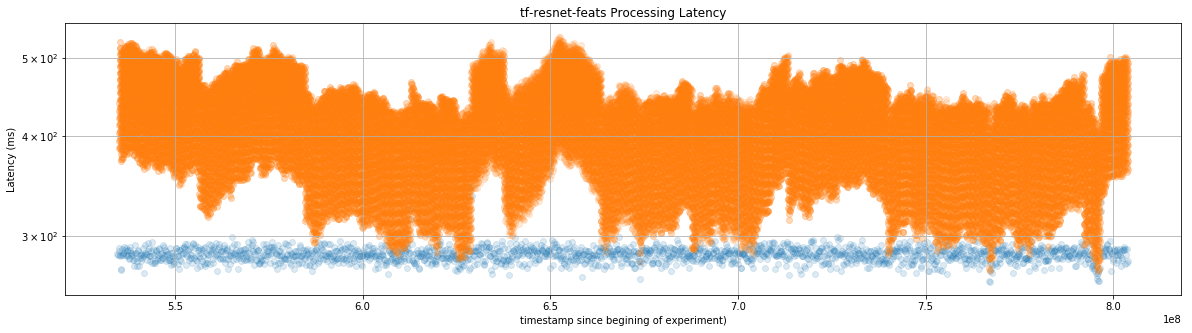

In [93]:
compare_latency_dists(resnet, resnet_models)
compare_latency_dists_over_time(resnet, resnet_models)

In [94]:
def get_arrival_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def get_outs_intervals(cached_extractions, model):
    outs = cached_extractions[model+":1:processing_outs"][:,1]
    timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = outs[1:] - outs[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrival_intervals, _ = get_arrival_intervals(cached_extractions, model, intra_batch_arrivals)
        outs_intervals, _ = get_outs_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        smoothLineHistogram(arrival_intervals, label=model+str(" arrival CV="+str(arrival_CV)))
        smoothLineHistogram(outs_intervals, label=model+str(" outs CV="+str(outs_CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        arrival_intervals, arrival_timestamps = get_arrival_intervals(cached_extractions, model, intra_batch_arrivals)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_intervals, outs_timestamps = get_outs_intervals(cached_extractions, model)
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(arrival_intervals),np.min(outs_intervals)), max(np.max(arrival_intervals),np.max(outs_intervals))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(arrival_timestamps, arrival_intervals, label="arrival CV="+str(arrival_CV), alpha = 0.3)
        plt.scatter(outs_timestamps, outs_intervals, label="outs CV="+str(outs_CV), alpha = 0.3)
        plt.legend()
    plt.show()


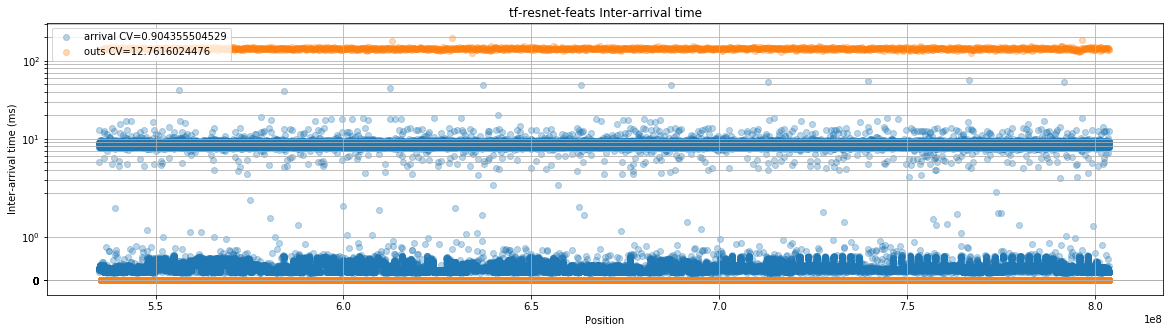

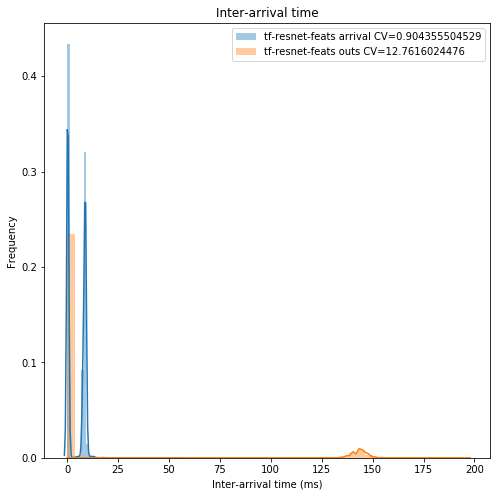

In [95]:
plot_inter_arrival_over_time(resnet, resnet_models, intra_batch_arrivals=True)
plot_inter_arrival(resnet, resnet_models, intra_batch_arrivals=True)

In [96]:
def arrival_curve_and_out_data(cached_extractions, model, N):
    arrival_timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    outs_timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    def get_smallest_delta(k, timestamps):
        current_delta = timestamps[k+1] - timestamps[0]
        min_so_far = current_delta
        for index in xrange(k + 1, len(timestamps)-1):
            delta_in = timestamps[index + 1] - timestamps[index]
            delta_out = timestamps[index-k] - timestamps[index-k-1]
            next_delta = current_delta - delta_out + delta_in
            if next_delta < min_so_far:
                min_so_far = next_delta
            current_delta = next_delta
        return current_delta
    arrival_x_axis = np.asarray([get_smallest_delta(i, arrival_timestamps) for i in xrange(1,N+1)])
    arrival_y_axis = 1+np.arange(N)
    outs_x_axis = np.asarray([get_smallest_delta(i, outs_timestamps) for i in xrange(1,N+1)])
    outs_y_axis = 1+np.arange(N)
    return arrival_x_axis, arrival_y_axis, outs_x_axis, outs_y_axis

def plot_arrival_and_out_curves(cached_extractions, model_list, N=50):
    plt.figure(figsize=(8,8))
    plt.title("Arrival curves")
    plt.xlabel("time-delta in ms")
    plt.ylabel("Queries")
    max_x = 0
    import itertools
    colors = itertools.cycle(('blue', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'grey'))
    for model in model_list:
        arrival_x_data, arrival_y_data, outs_x_data, outs_y_data = arrival_curve_and_out_data(cached_extractions, model, N)
        arrival_x_data = arrival_x_data / 1000 # converting to ms
        outs_x_data = outs_x_data / 1000 # converting to ms
        max_x = max(max_x, np.max(arrival_x_data), np.max(outs_x_data))
        color = colors.next()
        plt.plot(arrival_x_data, arrival_y_data, color = color, linestyle="--", label=model+" arrival curve")
        plt.plot(outs_x_data, outs_y_data, color = color, label=model+" service curve")
    plt.legend()
    y_jump = 1
    while N/y_jump > 30:
        y_jump*=2
    plt.yticks(np.arange(0, N+1, y_jump))
#     plt.xticks(np.arange(0, max_x+50, 50))
    plt.grid(True)
    plt.show()

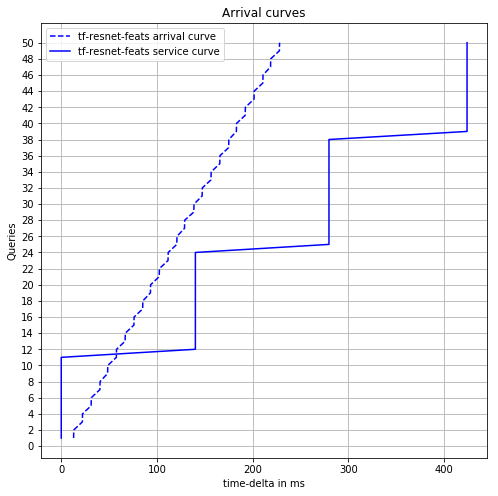

In [97]:
plot_arrival_and_out_curves(resnet, resnet_models)

In [67]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

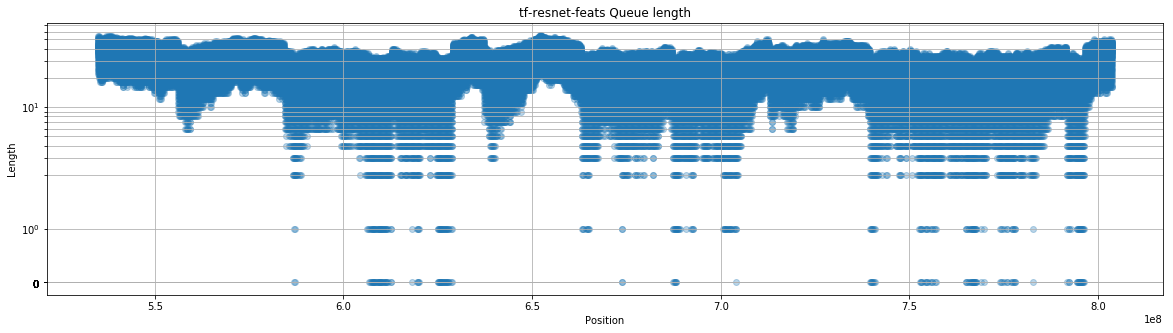

In [98]:
plot_ordinal_queue_sizes(resnet, resnet_models)

In [69]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

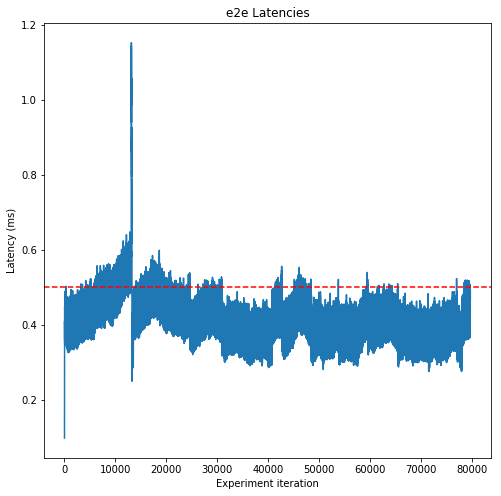

In [99]:
plot_e2e_lats(resnet_hollistic)

In [100]:
plot_mean_batch_sizes(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("Mean effective batchsizes")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

SyntaxError: invalid syntax (<ipython-input-100-594836f26b0a>, line 1)